### **Non-Linear Bias Measurement Notebook with FastPT:**

**Last Run: 11/17/2019**

For any questions, suggestions, or issues with the notebook please email Sam Goldstein at samgolds@sas.upenn.edu

**Summary:**

Computes the galaxy-galaxy, galaxy-matter, and matter-matter power spectra for galaxy and dark matter particle snapshot catalogs. Fits and compares models

**Outline:**

#### **Import Files and Setup Configuration:**

This cell imports the necessary libraries for the notebook, loads a catalog, and initializes cosmology parameters from the loaded catalog which will be used extensively throughout the notebook. Computes $\sigma_\chi$ defined as $\sigma_\chi = \frac{c}{H(z)}\sigma_z,$ and $\sigma_z \approx 0.05(1+z_{redshift})$. To read the OuterRim simulation data we must use the Genericio library.

In [1]:
import sys

fastpt_path = r"/global/u2/s/samgolds/FAST-PT/"
genericio_path = (r"/global/u2/s/samgolds/DC2-analysis/contributed/"
                  "nonlinear_bias/genericio/python/")

sys.path.append(fastpt_path)
sys.path.append(genericio_path)

from FASTPT import *
import genericio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pyccl
import sys
import GCRCatalogs

from scipy.constants import speed_of_light
from matplotlib.ticker import NullFormatter

sns.set(style='ticks')

%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'

# Global constants to be used in various computations
cat_str = "baseDC2_snapshot_z1.01_v0.1"
dark_matter_file = ("/global/projecta/projectdirs/lsst/groups/CS/"
                    "cosmoDC2/Outer_snapshots/z1.01/m000.mpicosmo.247")

def get_catalog_cosmology(cat_str):
    """
    Simple helper function to return catalog cosmology
    """
    
    cat = GCRCatalogs.load_catalog(cat_str)
    
    return cat.cosmology, cat.redshift

pi = np.pi
COSMO, Z_RED_SHIFT = get_catalog_cosmology(cat_str)

COSMO_CCL = pyccl.Cosmology(h=COSMO.h, sigma8=COSMO.sigma8,
                            Omega_g=COSMO.Ogamma0, Omega_k=COSMO.Ok0,
                            Omega_c=COSMO.Odm0, Omega_b=COSMO.Ob0,
                            n_s=COSMO.n_s, Neff=COSMO.Neff)

# Compute sigma chi
H0 = 71.0
SIGMA_Z = 0.05*(1+Z_RED_SHIFT)
SCALE_FACTOR = 1/(1+Z_RED_SHIFT)
H_Z = pyccl.background.h_over_h0(COSMO_CCL, SCALE_FACTOR)*H0

SIGMA_CHI = (speed_of_light/10**3)/H_Z*SIGMA_Z

# Select which direction is radial (X, Y, or Z)
RADIAL_DIR = "Z"

assert(str.lower(RADIAL_DIR)=="x" or 
       str.lower(RADIAL_DIR)=="y" or
       str.lower(RADIAL_DIR)=="z"), "Invalid Radial Coordinate Selection."

#### **Load and Mask Galaxy and Dark Mattter Particle Position Data:**

Defines functions to load galaxy and dark matter particle data and apply a Gaussian kernel in according to the radially defined position coordinate, $q_r$, to model radial distributions in a tomogrpahic redshift bin defined as $e^{-\frac{(q_r-\bar{q_r})^2}{2\sigma_\chi^2}}$. Coodinates are defined as $q_1, q_2, q_r$ corresponding to either $X$, $Y$ or $Z$ depending on the choice of radial direction as outlined below:
* X Radial Direction: $(q_1, q_2, q_r) = (Y, Z, X)$
* Y Radial Direction: $(q_1, q_2, q_r) = (X, Z, Y)$
* Z Radial Direction: $(q_1, q_2, q_r) = (X, Y, Z)$


Functions are defined to return minimal sufficient data to prevent memory errors when reading entire catalog.

In [2]:
def mask_positions(q1_data, q2_data, qr_data):
    """
    A helper function which applies a gaussian mask to select galaxies based on 
    their radial position data. q1 and q2 are used to reference perpendicular positions
    so if Z is radial then q1 = X and q2 = Y

    Parameters:
    q1_data (float array): np array containing first perpendicular positions of galaxies in Mpc
    q2_data (float array): np array containing second perpendicular positions of galaxies in Mpc
    radial_data (float array): np array containing radial positions of galaxies in Mpc

    Returns:
    q1_masked (float array): np array containing x positions of masked galaxies
    in Mpc
    q2_masked (float array): np array containing y positions of masked galaxies 
    in Mpc
    """
    
    # Apply Gaussian kernel with mean z_bar and std_dev = sigma_chi
    qr_bar = np.mean(qr_data)
    
    cutoffs = np.random.uniform(0, 1, len(qr_data))
    
    mask_ind = np.where(cutoffs < 
                        np.exp(-(qr_data-qr_bar)**2/(2*SIGMA_CHI**2)))[0]

    q1_masked = q1_data[mask_ind]
    q2_masked = q2_data[mask_ind]

    return q1_masked, q2_masked

def load_dark_matter_positions(file_str, x_bounds, y_bounds, z_bounds):
    """
    Loads and applies preliminary filters to dark matter position data in Mpc
    from a specified catalog and then applies a Gaussian kernel

    Parameters:
    file_str (string): location of file to load dark matter particles from
    x_bounds (float tuple): 2 element tuple with (x_min, x_max)
    y_bounds (float tuple): 2 element tuple with (y_min, y_max)
    z_bounds (float tuple): 2 element tuple with (z_min, z_max)

    Returns:
    x_masked (float array): np array containing x positions of galaxies in Mpc
    y_masked (float array): np array containing y positions of galaxies in Mpc
    """
    
    # Setup box bounds in Mpc
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    min_z, max_z = z_bounds
    
    # Load data from catalog using genericio
    x_data = np.array(genericio.gio_read(file_str, "x")[0])
    y_data = np.array(genericio.gio_read(file_str, "y")[0])
    z_data = np.array(genericio.gio_read(file_str, "z")[0])
    
    # Convert from Mpc/h to Mpc
    x_data *= 100/H0
    y_data *= 100/H0
    z_data *= 100/H0
    
    # Select particles within bounds
    bound_ind = np.where((x_data > min_x) & (x_data < max_x) &
                         (y_data > min_y) & (y_data < max_y) &
                         (z_data > min_z) & (z_data < max_z))
    
    x_data = x_data[bound_ind]
    y_data= y_data[bound_ind]
    z_data = z_data[bound_ind]
               
    # Apply Gaussian mask
    q1_masked = None  # First perpendicular coordinate post mask
    q2_masked = None  # Second perpendicular coordinate post mask
    
    if str.lower(RADIAL_DIR) == "x":
        q1_masked, q2_masked = mask_positions(y_data, z_data, x_data)
        
    elif str.lower(RADIAL_DIR) == "y":
        q1_masked, q2_masked = mask_positions(x_data, z_data, y_data)
        
    elif str.lower(RADIAL_DIR) == "z":
        q1_masked, q2_masked = mask_positions(x_data, y_data, z_data)
    else:
        raise(Exception("Invalid Radial Coordinate Selection"))
    
    return q1_masked, q2_masked


def load_galaxy_positions(cat_str, x_bounds, y_bounds, z_bounds, mag_cut):
    """
    Loads and applies preliminary filters to galaxy position data in Mpc
    from a specified catalog

    Parameters:
    cat (GCRCatalog): catalog to load data from
    x_bounds (float tuple): 2 element tuple with (x_min, x_max)
    y_bounds (float tuple): 2 element tuple with (y_min, y_max)
    z_bounds (float tuple): 2 element tuple with (z_min, z_max)
    mag_cut (float): apparent magnitude cut value (max value)

    Returns:
    x_masked (float array): np array containing x positions of galaxies in Mpc
    y_masked (float array): np array containing y positions of galaxies in Mpc
    """
    
    # Load catalog
    cat = GCRCatalogs.load_catalog(cat_str)
    
    # Setup box bounds in Mpc
    min_x, max_x = x_bounds
    min_y, max_y = y_bounds
    min_z, max_z = z_bounds
    
    print("Loading Galaxy Catalog Data: ")

    cat_vals = cat.get_quantities(["position_x", "position_y", "position_z",
                                   "Mag_true_r_lsst_z0"],
                                  filters=["position_z > {}".format(min_z),
                                           "position_z < {}".format(max_z),
                                           "position_x < {}".format(max_x),
                                           "position_x > {}".format(min_x),
                                           "position_y < {}".format(max_y),
                                           "position_y > {}".format(min_y)])
    
    print("Applying Apparent Magnitude Cut: ")

    # Convert absolute to apparent magnitude
    r_Mag = cat_vals["Mag_true_r_lsst_z0"]
    r_mag = r_Mag+cat.cosmology.distmod(Z_RED_SHIFT).value

    # Remove all entries below mag_cut
    filtered_indices = np.where(r_mag < mag_cut)[0]

    x_data = cat_vals["position_x"][filtered_indices]
    y_data = cat_vals["position_y"][filtered_indices]
    z_data = cat_vals["position_z"][filtered_indices]

    # Apply Gaussian mask
    q1_masked = None  # First perpendicular coordinate post mask (e.g. x, y, or z)
    q2_masked = None  # Second perpendicular coordinate post mask (e.g. x, y, or z)
    
    if str.lower(RADIAL_DIR) == "x":
        q1_masked, q2_masked = mask_positions(y_data, z_data, x_data)
        
    elif str.lower(RADIAL_DIR) == "y":
        q1_masked, q2_masked = mask_positions(x_data, z_data, y_data)
        
    elif str.lower(RADIAL_DIR) == "z":
        q1_masked, q2_masked = mask_positions(x_data, y_data, z_data)
    else:
        raise(Exception("Invalid Radial Coordinate Selection"))
    
    return q1_masked, q2_masked


def progress_bar(cur_val, final_val):
    """ 
    Simple function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

### **Loading Data:**
Most of cell below is commented out since we are only applying corrections to the galaxy power spectrum at the moment, so we donn't load the dark matter particles.

In [3]:
# Apply above defined functions to load dark matter particle and galaxy data

# Define boundaries/data constraints
mag_cut = 24.5  # Consider only galaxies with apparent magnitude above 24.5

x_bounds = (0, 4225)
y_bounds = (0, 4225)
z_bounds = (1112, 3112)

# Load dark matter particle data from first file
print("Loading Dark Matter Particle Data")
q1_data_dm, q2_data_dm = load_dark_matter_positions(dark_matter_file+"#0", 
                                                      x_bounds, y_bounds, z_bounds)

# Load dark matter particle data from remaining files
for i in range(1, 256):
    progress_bar(i, 256)
    q1_data_n, q2_data_n = load_dark_matter_positions(dark_matter_file+"#"+str(i), 
                                                        x_bounds, y_bounds, z_bounds)
    
    q1_data_dm = np.append(q1_data_dm, q1_data_n)
    q2_data_dm = np.append(q2_data_dm, q2_data_n)
    
    progress_bar(i, 256)

sys.stdout.flush()  # Clears output to prevent writing over progress bar
print("")

# Load galaxy data
q1_data_g, q2_data_g = load_galaxy_positions(cat_str, x_bounds, y_bounds, z_bounds, 
                                             mag_cut)

# Compute N_BAR_DM and N_BAR_G (average number of particles/galaxies per Mpc^2)
q1_width_dm = np.max(q1_data_dm)-np.min(q1_data_dm)
q2_width_dm = np.max(q2_data_dm)-np.min(q2_data_dm)
N_BAR_DM = len(q1_data_dm)/(q1_width_dm*q2_width_dm)

q1_width_g = np.max(q1_data_g)-np.min(q1_data_g)
q2_width_g = np.max(q2_data_g)-np.min(q2_data_g)
N_BAR_G = len(q1_data_g)/(q1_width_g*q2_width_g)

Loading Dark Matter Particle Data
Progress: [------------------->] 100%
Loading Galaxy Catalog Data: 
Applying Apparent Magnitude Cut: 


#### **Get Power-Spectra From Data:**

Code cell below defines a method for calculating the 2D power spectrum for x and y data with a specified resolution size *N* by computing the over-density field, 2-point correlation function, and then applying a 2D FFT. Additionally, a function is defined to compute the cross power spectrum using a similar procedure. Finally, a method is defined for averaging power spectrum values in bins of wavenumbers.

In [4]:
def calculate_auto_pow_spec(q1_data, q2_data,  N, bad_ind):
    """ 
    Calculates the 2D auto power spectrum from data with N*N grid. Removes zero
    order Fourier mode.

    Parameters:
    q1_data (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data (np float array): Array containing q2 positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^2
    """

    q1_min = np.floor(np.min(q1_data))
    q1_max = np.ceil(np.max(q1_data))
    q1_width = q1_max-q1_min
    
    q2_min = np.floor(np.min(q2_data))
    q2_max = np.ceil(np.max(q2_data))
    q2_width = q2_max-q2_min

    # Initialize Grid
    grid_matrix = np.histogram2d(q1_data, q2_data, N)[0]

    # Get the number of galaxies and set amount of data points per bin
    n_g = len(q1_data)

    delta_q1 = q1_width/N
    delta_q2 = q2_width/N

    # Convert grid to represent over_density
    p_bar = n_g/N**2  # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat)

    # Perform fourier transform
    delta_k = np.fft.fft2(delta)

    # Calculate power spectrum
    pow_spec = np.real(delta_k*np.conj(delta_k))/(N**2*N**2/(q1_width*q2_width))
    
    # Set the flawed wavenumbers to None in the pow_spec matrix
    bad_ind_key = 888888
    
    for ind in bad_ind:
        pow_spec[ind][0] = bad_ind_key
        
    p_k = pow_spec.flatten()
    
    # Get frequency values
    f_value = np.fft.fftfreq(N)
    kq1_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_q1)
    kq2_mat = np.outer(2.0*np.pi*f_value/delta_q2, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kq1_mat**2+(kq2_mat)**2)
    
    k_vals = k_mat.flatten()
    assert(len(k_vals) == len(p_k))
    
    # Remove flawed wavenumbers from final values    
    pow_ind = np.where(p_k != bad_ind_key)[0]
    k_vals = k_vals[pow_ind]
    p_k = p_k[pow_ind]
    
    assert(len(np.where(p_k==bad_ind_key)[0]) == 0)
    
    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]

def get_over_density(q1_data, q2_data, N):
    """
    Computes the over-density field from data with N*N grid. Used in cross power 
    spectrum computation

    Parameters:
    q1_data (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data (np float array): Array containing q2 positions of galaxies in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    delta (np float array): 2D NxN array with the over-density field computed from
    q1_data and q2_data

    """
    
    q1_min = np.floor(np.min(q1_data))
    q1_max = np.ceil(np.max(q1_data))
    q1_width = q1_max-q1_min
    
    q2_min = np.floor(np.min(q2_data))
    q2_max = np.ceil(np.max(q2_data))
    q2_width = q2_max-q2_min

    # Initialize Grid
    grid_matrix = np.histogram2d(q1_data, q2_data, N)[0]

    # Get the number of galaxies and set amount of data points per bin
    n_g = len(q1_data)

    delta_q1 = q1_width/N
    delta_q2 = q2_width/N

    # Convert grid to represent over_density
    p_bar = n_g/N**2  # No. galaxies expected per bin
    p_bar_mat = p_bar*np.ones_like(grid_matrix)

    delta = 1/p_bar*(grid_matrix-p_bar_mat)
    
    return delta

def calculate_cross_pow_spec(q1_data_g, q2_data_g, q1_data_dm, q2_data_dm,  N, bad_ind):
    """ 
    Calculates the 2D cross power spectrum from data with N*N grid. Removes zero
    order Fourier mode.

    Parameters:
    q1_data_g (np float array): Array containing q1 positions of galaxies in Mpc
    q2_data_g (np float array): Array containing q2 positions of galaxies in Mpc
    q1_data_dm (np float array): Array containing q1 positions of dark matter 
    particles in Mpc
    q2_data_dm (np float array): Array containing q2 positions of dark matter 
    particles in Mpc
    N (int): Integer representing the grid size for the power spec calculation

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^2
    """
    
    # Compute over-density
    delta_g = get_over_density(q1_data_g, q2_data_g, N)
    delta_dm = get_over_density(q1_data_dm, q2_data_dm, N)

    # Perform fourier transform
    delta_k_g = np.fft.fft2(delta_g)
    delta_k_dm = np.fft.fft2(delta_dm)

    # Calculate power spectrum
    pow_spec = np.real(delta_k_dm*np.conj(delta_k_g))
    
    # Normalize power spectrum 
    q1_width = np.ceil(np.max(q1_data_g))-np.floor(np.min(q1_data_g))
    q2_width = np.ceil(np.max(q2_data_g))-np.floor(np.min(q2_data_g))
    
    pow_spec /= (N**2*N**2/(q1_width*q2_width))
    
    # Set the flawed wavenumbers to None in the pow_spec matrix
    bad_ind_key = 888888 # Number to set bad indices to for future identification
    
    for ind in bad_ind:
        pow_spec[ind][0] = bad_ind_key
    
    p_k = pow_spec.flatten()
    
    # Get frequency values
    delta_q1 = q1_width/N
    delta_q2 = q2_width/N
    
    f_value = np.fft.fftfreq(N)
    kq1_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_q1)
    kq2_mat = np.outer(2.0*np.pi*f_value/delta_q2, np.ones(N))

    # Construct matrix of wave numbers
    k_mat = np.sqrt(kq1_mat**2+(kq2_mat)**2)
    
    k_vals = k_mat.flatten()
    
    assert(len(k_vals) == len(p_k))
    
    # Remove flawed wavenumbers from final values
    pow_ind = np.where(p_k != bad_ind_key)[0]
    k_vals = k_vals[pow_ind]
    p_k = p_k[pow_ind]
    
    assert(len(np.where(p_k==bad_ind_key)[0]) == 0)
    
    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]
    

def average_pow_spec(k_vals, p_vals, n_bins):
    """
    Averages power spectrum into n_bins based on k
    
    Parameters:
    k_vals (np float array): array containing the unaverged wave numbers in 
    Mpc^-1
    p_k (np float array): array containing the unaveraged power spectrum values in
    Mpc^2
    n_bins (int): integer representing the number of bins to average values into

    Returns:
    averaged_k (np float array): array containing the averaged wave numbers in
    Mpc^-1
    averaged_p (np float array): array containing the averged power spectrum values in
    Mpc^2
    n_modes (np int array): array containing the number of Fourier modes in each bin of 
    averaged_k/averaged_p
    """

    averaged_p, averaged_k, binnumbers = scipy.stats.binned_statistic(k_vals, p_vals, 'mean', bins=n_bins)
    
    # Compute average wave number of each bin
    averaged_k = averaged_k+(averaged_k[1]-averaged_k[0])/2
    
    # Calculate n_modes from bin number
    n_modes = np.bincount(binnumbers)[1:]
    
    return averaged_k[:-1], averaged_p, n_modes

#### **Compute Galaxy, Dark Matter Particle Auto and Cross Power Spectra:**

Uses the above defined functions to compute the relevant power spectrum on an array of size $N$ and averages the data into $N_{avg}$ points according to wavenumber.

In [5]:
# Array of dimension, N, to compute the power spectrum over
N = 10000
N_avg = 1024

# Select indices to exclude (accounting for simulation bin errors)
bad_ind = np.array([64, 128, 192, 256])
bad_ind = np.append(bad_ind, np.flip(N-bad_ind))

print("Calculating Galaxy Power Spectrum")
k_g, p_gg, n_modes_g = average_pow_spec(*calculate_auto_pow_spec(q1_data_g, q2_data_g, N, bad_ind), N_avg)


print("Calculating Dark Matter Power Spectrum ")
k_dm, p_dm, n_modes_dm = average_pow_spec(*calculate_auto_pow_spec(q1_data_dm, q2_data_dm, N, bad_ind), N_avg)

print("Calculating Cross Power Spectrum")
k_cross, p_gm, n_modes_cross = average_pow_spec(*calculate_cross_pow_spec(q1_data_g, q2_data_g, q1_data_dm,
                                                                               q2_data_dm,  N, bad_ind), N_avg)

# Ensure all power spectrum values have the same wave number and each bin has same number of modes
assert(all((k_g == k_dm) & (k_g == k_cross)))
k = k_g

assert(all((n_modes_g == n_modes_dm) & (n_modes_g==n_modes_cross)))
n_modes = n_modes_g

k = k_g
n_modes = n_modes_g

Calculating Galaxy Power Spectrum
Calculating Dark Matter Power Spectrum 
Calculating Cross Power Spectrum


#### **Fit Linear Models**

We first fit the one and two parameter bias models for $P_{gg}$. Code cell below contains definitions for computing the 2D power spectrum for one an two bias parameter models defined as follows:

1. Define the power spectrum $P(k_\parallel, k_\perp)$ using the linear/non-linear matter power spectrum function using CCL, where $k = \sqrt{k_\parallel^2+k_\perp^2}$
2. Integrate over a range of values for $k_\parallel$ using the integral defined below to compute a theoretical estimate for the 2D matter power spectrum using a one or two bias parameter model
    * **Single Parameter Model:**
$$P(k_\perp) = \frac{b_1^2}{\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n}}$$

    * **Two Parameter Model:**
$$P(k_\perp) = \frac{1}{\pi}\int\limits_{0}^{\infty}(b_1+b_1'k)^2P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel+\frac{1}{\overline{n}}$$

In [16]:
def get_pow_2d(k_perp, b, is_linear):
    """
    Computes the theoretical 2d galaxy power spectrum with one or two parameter
    linear/non-linear model depending on input parameters

    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    calculating with two parameter model
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    p_theory (float array): array containing the theoretical power spectrum
    values associated with the inputed k_perp
    
    """

    def integrand_func(k_par, k_perp, b):

        k = np.sqrt(k_perp**2+k_par**2)

        if is_linear:
            P_k = pyccl.linear_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))

        else:
            P_k = pyccl.nonlin_matter_power(COSMO_CCL, k,
                                            COSMO.scale_factor(Z_RED_SHIFT))
    
        # Compute the appropriate model depending on the number of parameters 
        # in b_guess
        
        if len(b)==2:
            return (b[0]+b[1]*k)**2*P_k*np.exp(-(k_par*SIGMA_CHI)**2)

        else:
            return b[0]**2*P_k*np.exp(-(k_par*SIGMA_CHI)**2)             

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp, b))[0])

    p_theory = 1/(np.pi)*integrator(k_perp)+1/N_BAR_G

    return p_theory


def neg_log_like(b, k_perp, p_k, n_modes, is_linear):
    """
    Returns the negative log likelihood for a given bias parameter associated with
    linear or non-linear power spectrum. Used for fitting model parameters

    Parameters:
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    neg_log_like (float): the negative of the log-likelihood of the data given the 
    model specified by input parameters
    
    """
    
    # Compute theoretical power spectrum from model
    p_theory = get_pow_2d(k_perp, b, is_linear)
    
    # Compute variance, chi_sq, then negative log likelihood
    var_t = 2*p_theory**2/n_modes
    chi_sq = np.sum((p_k-p_theory)**2/var_t)
    
    neg_log_like = chi_sq/2+np.sum(np.log(np.sqrt(var_t)))
    
    return neg_log_like


def calc_chi_sq(b, k, p_k, n_modes, is_linear):
    """    
    Returns the chi_sq values for a given bias parameter associated with linear 
    or non-linear power spectrum for each data point associated with k_perp

    Parameters:
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    chi_sq (float array): array containing the computed chi_2 of each data point for
    input parameter specified model

    """
    
    # Compute variance, chi_sq, then negative log likelihood
    p_theory = get_pow_2d(k, b, is_linear)
    var_t = 2*p_theory**2/n_modes
    
    chi_sq = (p_k-p_theory)**2/var_t

    return chi_sq

def fit_to_kmax(k_max_arr, k_perp, p_k, n_modes, b_guess, is_linear):
    """
    A function to fit data with specified model over a wavenumber interval upto 
    a particular kmax and determine statistics of each fit (chi^2cdf and reduced 
    chi^2)

    Parameters:
    k_max_arr (float array): array containing the maximum k_perps over which to compute 
    the power spectrum on subsets of k_perp
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    b_guess (float or list): float if single bias parameter, list [b1, b1'] if
    calculating with two parameter model does not need to be particularly accurate,
    just used to specify how many parameters the model has
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    b_arr (2d array): 2d array containing optimal parameters for each fit up to k_max, 
    e.g. for one parameter each entry is of the form [b1] and for two parameters each entry
    is of the form [b1, b2]
    chi_sq_cdf_arr (float array): returns the computed chi_sq cdf associated with each model 
    fit to k_max
    reduced_chi_sq_arr (float array): returns the reduced chi_sq associated with each model
    fit to k_max
    """    
    
    # Create empty arrays to fill with optimal parameters
    b_arr = np.empty_like(k_max_arr, dtype = np.ndarray)
    chi_sq_cdf_arr = np.zeros_like(k_max_arr)
    reduced_chi_sq_arr = np.zeros_like(k_max_arr)
    
    for ind, k_max in enumerate(k_max_arr):
        progress_bar(ind, len(k_max_arr))

        # Pick appropriate subset of values less than k_max_arr
        subset_indices = np.where((k_perp < k_max))
        k_subset = k_perp[subset_indices]
        p_k_subset = p_k[subset_indices]
        n_modes_subset = n_modes[subset_indices]

        # Maxmize log likelihood
        res = scipy.optimize.minimize(neg_log_like, b_guess,
                                      method='Nelder-Mead',
                                      args=(k_subset, p_k_subset,
                                            n_modes_subset, is_linear))

        # Compute total chi^2
        chi_2 = np.sum(calc_chi_sq(res.x, k_subset, p_k_subset, n_modes_subset,
                                  is_linear))
        # Fill arrays
        b_arr[ind] = res.x
        chi_sq_cdf_arr[ind] = scipy.stats.chi2.cdf(chi_2, df=len(k_subset))
        reduced_chi_sq_arr[ind] = chi_2/len(k_subset)

        progress_bar(ind+1, len(k_max_arr))

    return b_arr, chi_sq_cdf_arr, reduced_chi_sq_arr

#### **Apply a for One and Two Parameter Models:**
Determine optimal bias parameters over a fit window, for the one and two parameter models with no fastpt corrections. Compute the Akaike Information Criterion(AIC) associated with each model. We use modified AIC to account for small sample size.
$$AICc=2m-2\log(\mathcal{L})+\frac{2m^2+2m}{m-n-1}$$
where $m$ is sample size and $n$ is number of model parameters.

In [25]:
#-------------------------------------FIT AND CONSTRUCT MODEL 1-------------------------------------#
# Fit over a specified k interval
k_min_fit = 0.0
k_max_fit = 0.1

is_linear = True

fit_indices = np.where((k < k_max_fit) & (k > k_min_fit))
k_fit = k[fit_indices]
p_k_fit = p_gg[fit_indices]
n_modes_fit = n_modes_g[fit_indices]

b_guess = [1.7]
N_BAR = N_BAR_G
n_param = 1
res = scipy.optimize.minimize(neg_log_like, b_guess, method='Nelder-Mead',
                                      args=(k_fit, p_k_fit, n_modes_fit, 
                                            is_linear))
# Compute AIC of this model
log_L = -(neg_log_like(res.x, k, p_gg, n_modes, is_linear=True))
AICc = 2*1-2*log_L+(2*n_param**2+2*n_param)/(n_param-len(k_fit)-1)

# Compute AIC for this model on subset of k
k_min_aic= 0.0
k_max_aic = 1.0

is_linear = True

aic_indices = np.where((k < k_max_aic) & (k > k_min_aic))
k_aic = k[aic_indices]
p_gg_aic = p_gg[aic_indices]
n_modes_aic = n_modes_g[aic_indices]

log_L_sub = -(neg_log_like(res.x, k_aic, p_gg_aic, n_modes_aic, is_linear=True))
AICc_sub = 2*1-2*log_L_sub+(2*n_param**2+2*n_param)/(n_param-len(k_fit)-1)

# Store model info in dictionary
model_1 = {
    "k_min": k_min_fit,
    "k_max": k_max_fit,
    "n_param": n_param,
    "n_data": len(k_fit),
    "b": res.x,
    "AICc": AICc,
    "AICc_sub": AICc_sub
}

#-------------------------------------FIT AND CONSTRUCT MODEL 2-------------------------------------#
# Fit over a specified k interval
k_min_fit = 0.0
k_max_fit = 0.3

is_linear = True

fit_indices = np.where((k < k_max_fit) & (k > k_min_fit))
k_fit = k[fit_indices]
p_gg_fit = p_gg[fit_indices]
n_modes_fit = n_modes_g[fit_indices]

b_guess = [1.7, 1.0]
N_BAR = N_BAR_G
n_param = 2
res = scipy.optimize.minimize(neg_log_like, b_guess, method='Nelder-Mead',
                                      args=(k_fit, p_gg_fit, n_modes_fit, 
                                            is_linear))
# Compute AIC of this model
log_L = -(neg_log_like(res.x, k, p_gg, n_modes, is_linear=True))
AICc = 2*1-2*log_L+(2*n_param**2+2*n_param)/(n_param-len(k_fit)-1)

# Compute AIC for this model on subset of k
k_min_aic= 0.0
k_max_aic = 1.0

is_linear = True

aic_indices = np.where((k < k_max_aic) & (k > k_min_aic))
k_aic = k[aic_indices]
p_gg_aic = p_gg[aic_indices]
n_modes_aic = n_modes_g[aic_indices]

log_L_sub = -(neg_log_like(res.x, k_aic, p_gg_aic, n_modes_aic, is_linear=True))
AICc_sub = 2*1-2*log_L_sub+(2*n_param**2+2*n_param)/(n_param-len(k_fit)-1)

# Store model info in dictionary
model_2 = {
    "k_min": k_min_fit,
    "k_max": k_max_fit,
    "n_param": n_param,
    "n_data": len(k_fit),
    "b": res.x,
    "AICc": AICc,
    "AICc_sub": AICc_sub
}

#### **Apply Corrections Using FastPT:**
Use FastPT to compute the corrections to the power spectrum and construct appropriate interpolators for each correction term. Models are of the following form:

$$P_{gg}^{sub} = (b_1^ 2(P_k+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2((Pd_2d_2) - 2(sig4_k)) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2 - \frac{4}{3}(sig4_k)) + \frac{1}{4}b_s^2 (Ps_2s_2) - \frac{8}{9}(sig4_k))+\frac{1}{\overline{N}}$$

$$P_{gg} = (b_1^ 2(P_k+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2((Pd_2d_2) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2)+ \frac{1}{4}b_s^2 (Ps_2s_2)+\frac{1}{\overline{N}}$$


$$P_{mg} = b_1 (P_k+oneloopkz) + \frac{1}{2}b_2(Pd_1d_2) +\frac{1}{2}b_s(Pd_1s_2)$$

In [27]:
# Compute the linear mps for perpendicular wave numbers
k_thr = np.logspace(np.log10(0.9*np.min(k)), np.log10(1.1*np.max(k)), 1000) # Array of wave numbers for FastPT calculation
k_interp = np.logspace(np.log10(0.9*np.min(k_thr)), np.log10(1.1*np.max(k_thr)), 10000) # Array of wavenumbers for FastPt correction intepolators
P_lin = pyccl.linear_matter_power(COSMO_CCL, k_interp, COSMO.scale_factor(Z_RED_SHIFT))
Growth = 1

# Setup Fourier Coefficient Window and padding
C_window=.75
P_window=None
n_pad=int(0.5*len(k_interp))
to_do=['dd_bias']

# Initialize the FASTPT class
fastpt=FASTPT(k_interp,to_do=to_do, n_pad=n_pad)

# Compute one loop bias
bias_fpt = fastpt.one_loop_dd_bias(P_lin, P_window=P_window, C_window=C_window)

# Compute correction terms and construct appropriate interpolators
one_loopkz = Growth**4 * bias_fpt[0]
Pd1d2 = Growth**4 * bias_fpt[2]
Pd2d2 = Growth**4 * bias_fpt[3]
Pd1s2 = Growth**4 * bias_fpt[4]
Pd2s2 = Growth**4 * bias_fpt[5]
Ps2s2 = Growth**4 * bias_fpt[6]
sig4kz = Growth**4 * bias_fpt[7] * np.ones_like(bias_fpt[0])

P_lin_interp = scipy.interpolate.interp1d(k_interp, P_lin) # Not in use now but can be implemented to clean up future code
one_loop_interp = scipy.interpolate.interp1d(k_interp, one_loopkz)
Pd1d2_interp = scipy.interpolate.interp1d(k_interp, Pd1d2)
Pd2d2_interp = scipy.interpolate.interp1d(k_interp, Pd2d2)
Pd1s2_interp = scipy.interpolate.interp1d(k_interp, Pd1s2)
Pd2s2_interp = scipy.interpolate.interp1d(k_interp, Pd2s2)
Ps2s2_interp = scipy.interpolate.interp1d(k_interp, Ps2s2)
sig4kz_interp = scipy.interpolate.interp1d(k_interp, sig4kz)
    
    
def get_pow_2d_correction(k_perp_arr, interp):
    """
    Computes the 2d power spectrum corrections for an associated interpolator
    
    Parameters:
    k_perp (float array): array containing the wave numbers over which to
    compute the power spectrum
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    interp (scipy interp1d): interpolator that has the associated correction factors
    for a range of wavenumbers

    Returns:
    correction (float array): array containing the integrated correction term weighted with
    Gaussian kernel
    
    """
    
    def integrand_func(k_par, k_perp):
        """
        Interpolator values to be summed over perpendicular wave numbers weighted with Gaussian kernel
        """
        k = np.sqrt(k_perp**2+k_par**2)
        
        return interp(k)*np.exp(-(k_par*SIGMA_CHI)**2)  

    # Integrate over parallel wavenumbers
    integrator = np.vectorize(lambda k_perp: scipy.integrate.quad(
        integrand_func, 0, 0.5, args=(k_perp))[0])

    correction = 1/(np.pi)*integrator(k_perp_arr)
    
    return correction 

Initializing k-grid quantities...


#### **Fit Bias Parameters:**
Fit $b_1$ and $b_2$ bias parameters simultaneously.

$$P_{gg}^{sub} = b_1^ 2(P_k^{lin}+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2((Pd_2d_2) - 2(sig4_k)) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2 - \frac{4}{3}(sig4_k)) + \frac{1}{4}b_s^2 (Ps_2s_2) - \frac{8}{9}(sig4_k))+\frac{1}{\overline{N}}$$

$$P_{gg} = b_1^ 2(P_k^{lin}+oneloop_k) + b_1b_2 (Pd_1d_2) + (\frac{1}{4}) b_2^2(Pd_2d_2) + b_1b_s(Pd_1s_2) +
                  \frac{1}{2}b_2b_s(Pd_2s_2)+ \frac{1}{4}b_s^2 (Ps_2s_2)+\frac{1}{\overline{N}}$$


$$P_{mg} = b_1 (P_k^{lin}+oneloopkz) + \frac{1}{2}b_2(Pd_1d_2) +\frac{1}{2}b_s(Pd_1s_2)$$

In [28]:
print("Computing Fast PT Corrections")
# Computes the fast pt corrections and linear matter power spectra at the wavenumbers corresponding
# to measured power spectrum entries

p_lin = get_pow_2d(k, [1], is_linear)-1/N_BAR_G # 2D linear matter power spectrum without any shot-noise
p_one_loop = get_pow_2d_correction(k, one_loop_interp)
Pd1d2 = get_pow_2d_correction(k, Pd1d2_interp)
Pd2d2 = get_pow_2d_correction(k, Pd2d2_interp)
Pd1s2 = get_pow_2d_correction(k, Pd1s2_interp)
Pd2s2 = get_pow_2d_correction(k, Pd2s2_interp)
Ps2s2 = get_pow_2d_correction(k, Ps2s2_interp)
sigk4kz= get_pow_2d_correction(k, sig4kz_interp)

print("Fast PT Analysis Complete")

Computing Fast PT Corrections
Fast PT Analysis Complete


In [29]:
def pgg_model(b, k):
    """
    Function to define the galaxy auto power spectrum model you wish to fit using FastPT corrections
    
    Input: 
    b (float array): an array containing all of the bias parameters for the model
    
    Returns:
    Float array of computed values of pgg based on input model
    """
    b1 = b[0]
    b2 = b[1]
    bs = (-4./7)*(b1-1)
    
    n = len(k) # Determines how many of the power spectra values are fit up to
    
    model = b1**2*(p_lin[0:n]+p_one_loop[0:n])+b1*b2*Pd1d2[0:n]+1/4*b2**2*Pd2d2[0:n]+b1*bs*(Pd1s2[0:n])+1/2*b2*bs*Pd2s2[0:n]+1/4*bs**2*Ps2s2[0:n]+1/N_BAR_G
    
    return model

def pgm_model(b, k):
    """
    Function to define the galaxy/matter cross power spectrum model you wish to fit using FastPT corrections
   
    Input: 
    b (float array): an array containing all of the bias parameters for the model
    
    Returns:
    Float array of computed values of pgm based on input model
    """
    
    b1 = b[0]
    b2 = b[1]
    bs = (-4./7)*(b1-1)
    
    return b1*(p_lin+p_one_loop)+1/2*b2*Pd1d2+1/2*bs*Pd1s2


def neg_log_like(b, k_perp, p_k, n_modes, is_linear):
    """
    Returns the negative log likelihood for a given bias parameter associated with
    linear or non-linear power spectrum. Used for fitting model parameters

    Parameters:
    b (list): list with the bias parameters for given model (e.g. [b1, b1']
    for two parameter model)
    k_perp (float array): array containing the perpendicular wave numbers over which to
    compute the power spectrum
    p_k (float array): array containing power spectrum data associated with k_perp
    n_modes (int array): array containing number of Fourier modes in each k_perp bin
    is_linear (boolean): boolean representing whether or not to use the
    CCL linear MPS (alternative is non-linear MPS)

    Returns:
    neg_log_like (float): the negative of the log-likelihood of the data given the 
    model specified by input parameters
    """
    
    # Compute theoretical power spectrum from model
    p_theory = pgg_model(b, k_perp)
    
    # Compute variance, chi_sq, then negative log likelihood
    var_t = 2*p_theory**2/n_modes
    chi_sq = np.sum((p_k-p_theory)**2/var_t)
    
    neg_log_like = chi_sq/2+np.sum(np.log(np.sqrt(var_t)))
    
    return neg_log_like


# Fit over a specified k interval
k_min_fit = 0.00
k_max_fit = 1.0

is_linear = True

fit_indices = np.where((k < k_max_fit) & (k > k_min_fit))
k_fit = k[fit_indices]
p_k_fit = p_gg[fit_indices]
n_modes_fit = n_modes_g[fit_indices]
n_param = 2
b_guess = [1.0, 1.0]

res = scipy.optimize.minimize(neg_log_like, b_guess, method='Nelder-Mead',
                              args=(k_fit, p_k_fit, n_modes_fit, 
                                    is_linear))

# Compute AIC of this model
log_L = -(neg_log_like(res.x, k, p_gg, n_modes, is_linear=True))
AICc = 2*1-2*log_L+(2*n_param**2+2*n_param)/(n_param-len(k_fit)-1)

# Compute AIC for this model on subset of k
k_min_aic= 0.0
k_max_aic = 1.0

is_linear = True

aic_indices = np.where((k < k_max_aic) & (k > k_min_aic))
k_aic = k[aic_indices]
p_gg_aic = p_gg[aic_indices]
n_modes_aic = n_modes_g[aic_indices]

log_L_sub = -(neg_log_like(res.x, k_aic, p_gg_aic, n_modes_aic, is_linear=True))
AICc_sub = 2*1-2*log_L_sub+(2*n_param**2+2*n_param)/(n_param-len(k_fit)-1)

# Store model info in dictionary
model_3 = {
    "k_min": k_min_fit,
    "k_max": k_max_fit,
    "n_param": n_param,
    "n_data": len(k_fit),
    "b": res.x,
    "AICc": AICc,
    "AICc_sub": AICc_sub
}

#### **Plot Final Power Spectra and Models and Compare Models:**

In [36]:
# Compute corrections over large range of wavenumbers to make models look nice
# Compute power spectrum and associated corrections
print("Computing Fast PT Corrections")
p_lin = get_pow_2d(k_thr, [1], is_linear)-1/N_BAR_G
p_one_loop = get_pow_2d_correction(k_thr, one_loop_interp)
Pd1d2 = get_pow_2d_correction(k_thr, Pd1d2_interp)
Pd2d2 = get_pow_2d_correction(k_thr, Pd2d2_interp)
Pd1s2 = get_pow_2d_correction(k_thr, Pd1s2_interp)
Pd2s2 = get_pow_2d_correction(k_thr, Pd2s2_interp)
Ps2s2 = get_pow_2d_correction(k_thr, Ps2s2_interp)
sigk4kz= get_pow_2d_correction(k_thr, sig4kz_interp)

print("Fast PT Analysis Complete")

Computing Fast PT Corrections
Fast PT Analysis Complete


AICc Values:
Model 1: 7289625.583596463
Model 2: 133018.68064468759
Model 3: 1189795.5369081292
AICc Values for 0<k<1.0:
Model 1: 728913.8787697976
Model 2: 10379.51347513754
Model 3: 502.74822336517434


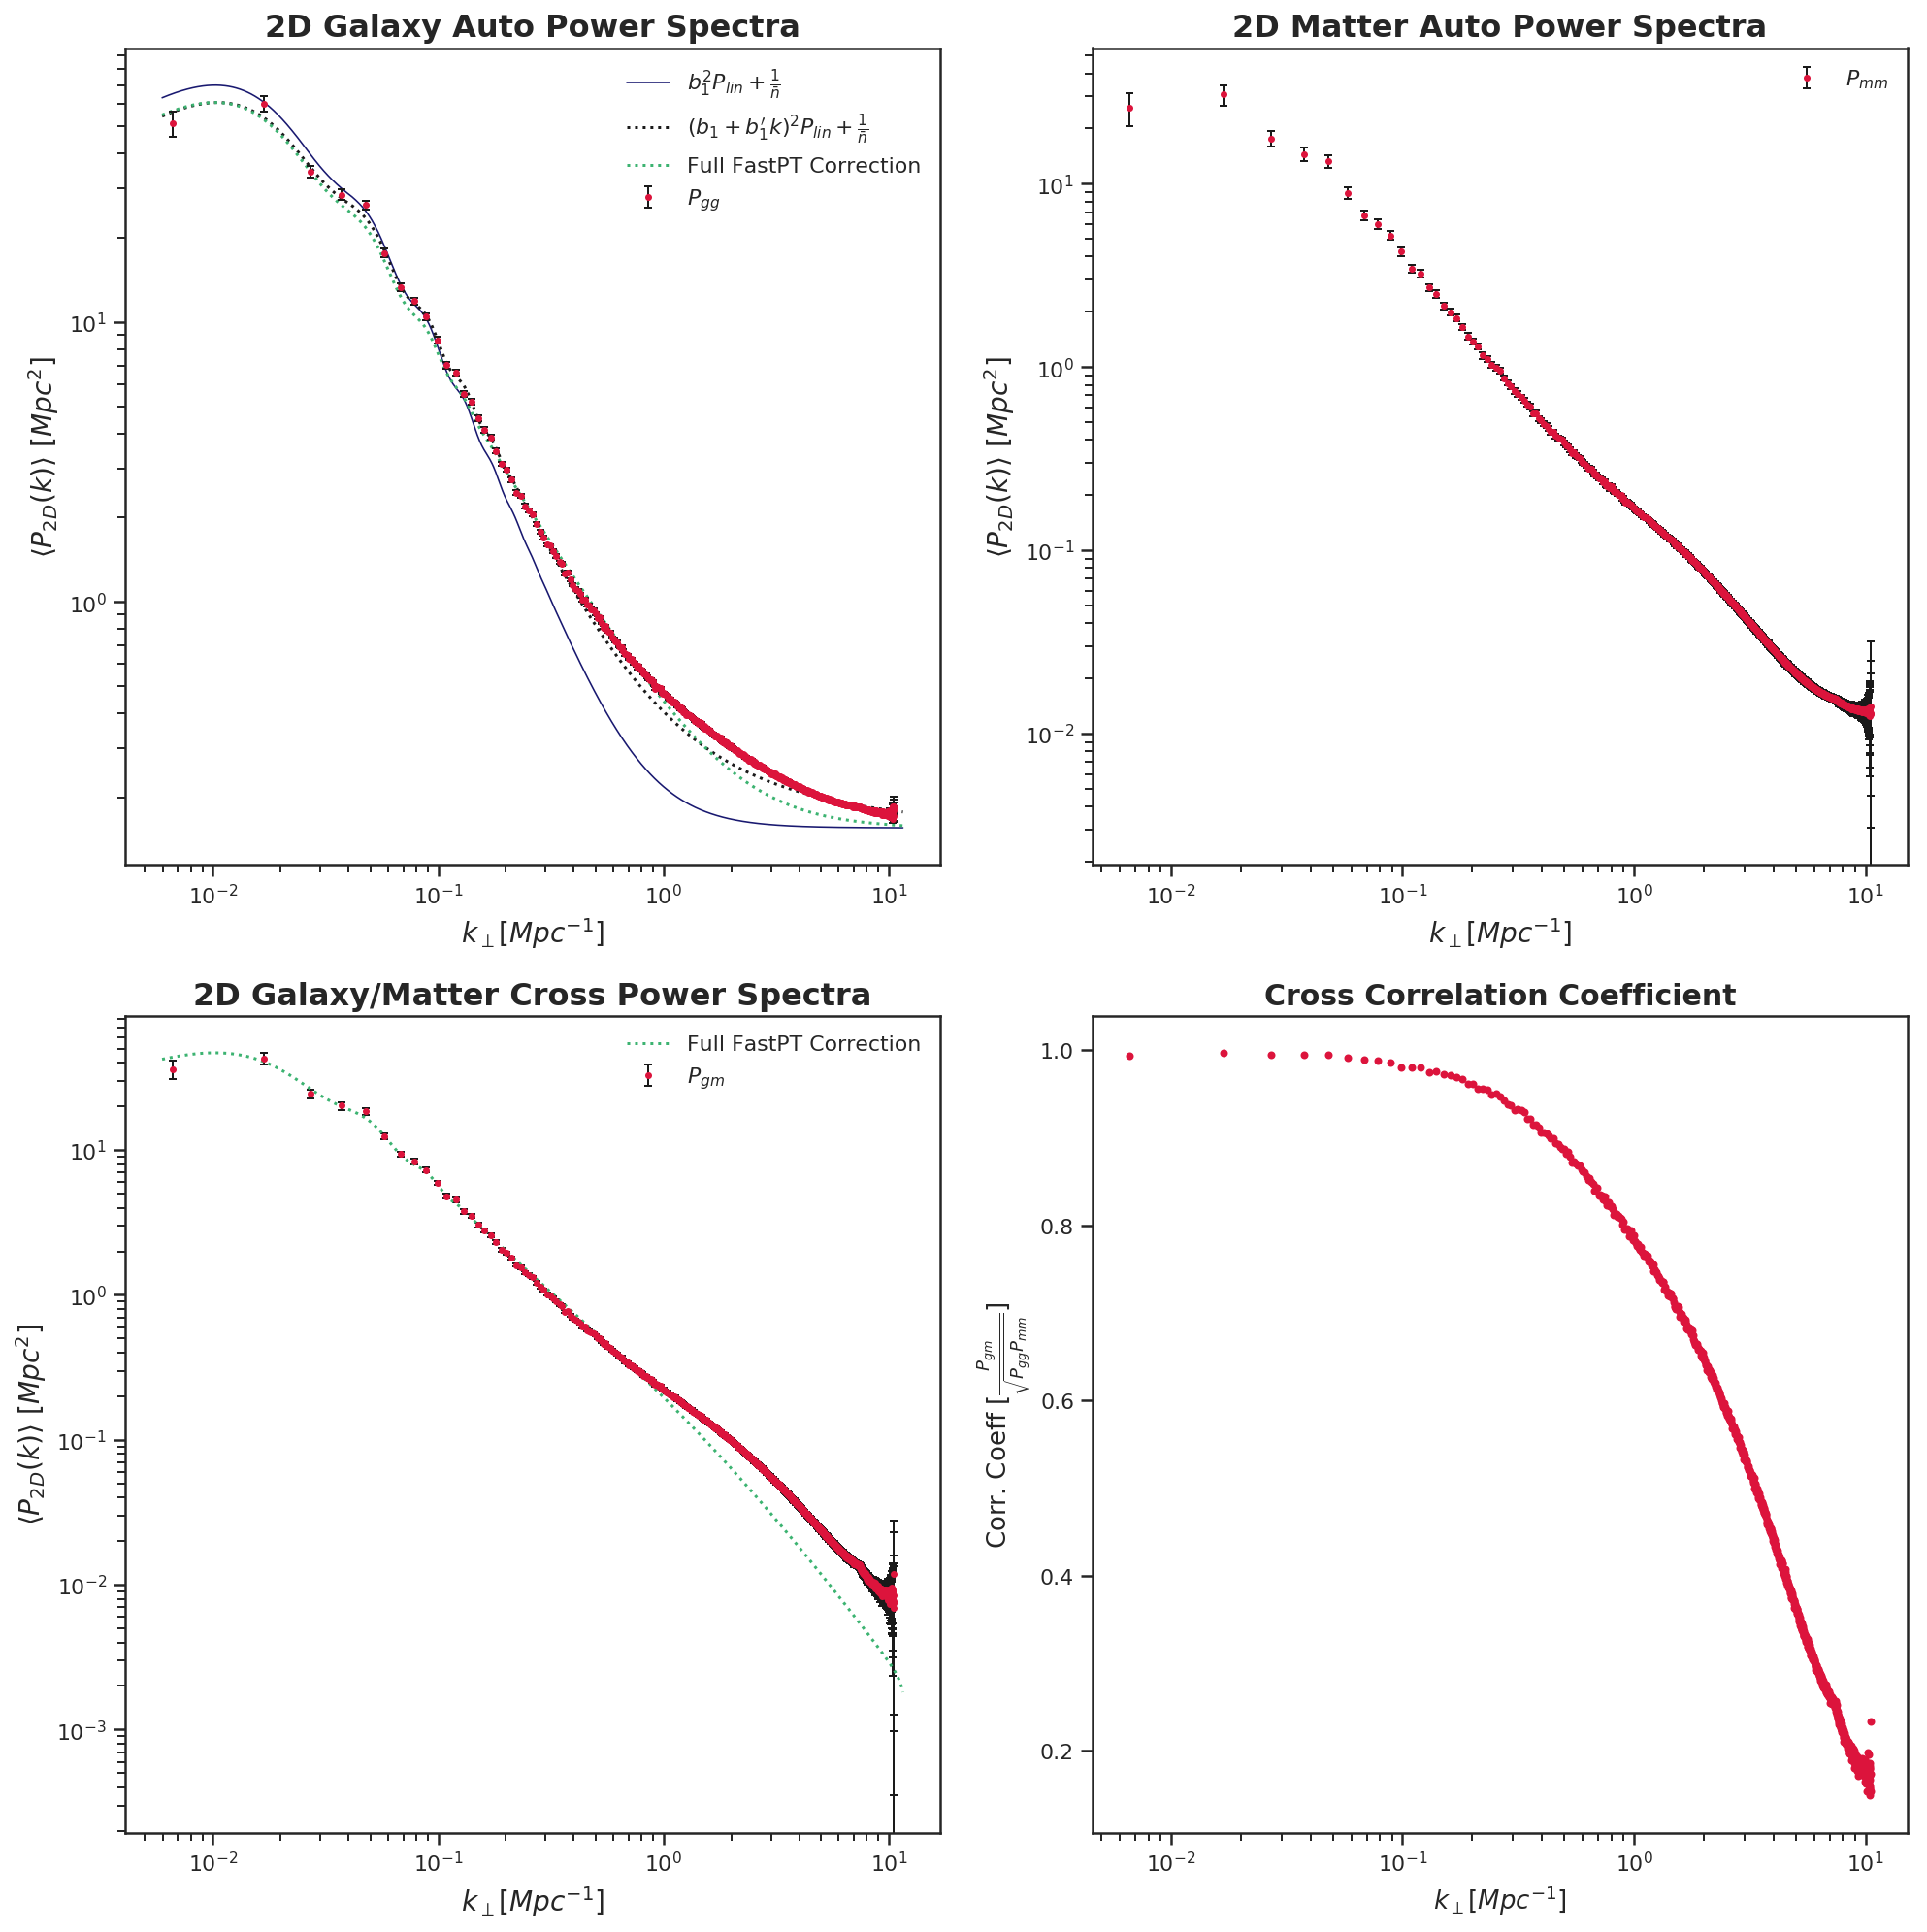

In [38]:
plt.figure(figsize=(14,14))


#-----------------------Plot Galaxy Auto Power Spectra--------------------------
plt.subplot(2,2,1)

plt.plot(k_thr, get_pow_2d(k_thr, model_1["b"], True), label=r"$b_1^2P_{lin}+\frac{1}{\bar{n}}$", color="midnightblue",
        linewidth=0.8)
plt.plot(k_thr,get_pow_2d(k_thr, model_2["b"], True), label=r"$(b_1+b_1'k)^2P_{lin}+\frac{1}{\bar{n}}$", 
         linestyle=":", color="k")
plt.plot(k_thr, pgg_model(model_3["b"], k_thr), label=r"Full FastPT Correction", 
         linestyle=":", color="mediumseagreen")
plt.errorbar(k, p_gg, 
             yerr=np.sqrt(2*p_gg**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"$P_{gg}$")

# Format legend
plt.legend(frameon=False)

# Add Labels
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=14)
plt.title("2D Galaxy Auto Power Spectra", fontweight="bold", fontsize=16)
plt.xscale("log")
plt.yscale("log")

#-----------------------Plot Matter Auto Power Spectra--------------------------
plt.subplot(2,2,2)

plt.errorbar(k, p_dm, 
             yerr=np.sqrt(2*p_gg**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"$P_{mm}$")

# Format legend
plt.legend(frameon=False)

# Add Labels
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=14)
plt.title("2D Matter Auto Power Spectra", fontweight="bold", fontsize=16)
plt.xscale("log")
plt.yscale("log")


#----------------------Plot Galaxy/Matter Cross Power Spectra----------------------
plt.subplot(2,2,3)

plt.errorbar(k, p_gm, 
             yerr=np.sqrt(2*p_gg**2/n_modes), 
             marker = '.', color = "crimson", linestyle = "none",
             markersize = 5, ecolor = 'k', elinewidth = 1, capsize=2, 
             markeredgewidth=1, label=r"$P_{gm}$")
plt.plot(k_thr, pgm_model(model_3["b"], k_thr), label=r"Full FastPT Correction", 
         linestyle=":", color="mediumseagreen")

# Format legend
plt.legend(frameon=False)

# Add Labels
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize = 14)
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle \ [Mpc^{2}]$", fontsize=14)
plt.title("2D Galaxy/Matter Cross Power Spectra", fontweight="bold", fontsize=16)
plt.xscale("log")
plt.yscale("log")


#----------------------Plot Cross Correlation Coefficient----------------------
plt.subplot(2,2,4)

# Compute cross correlation coefficient
cross_corr_coef = p_gm/np.sqrt(p_gg*p_dm)

plt.plot(k, cross_corr_coef, '.', color = "crimson")

plt.xscale("log")
plt.title("Cross Correlation Coefficient", fontweight = "bold", fontsize=15)
plt.xlabel(r"$k_\perp [Mpc^{-1}]$", fontsize=13)
plt.ylabel(r"Corr. Coeff [$\frac{P_{gm}}{\sqrt{P_{gg} P_{mm}}}$]", fontsize=13)

plt.tight_layout()

plt.savefig("fastpt_correction.png", dpi=250)

# Display AICC
print("AICc Values:")
print("Model 1: {}".format(model_1["AICc"]))
print("Model 2: {}".format(model_2["AICc"]))
print("Model 3: {}".format(model_3["AICc"]))

print("AICc Values for 0<k<1.0:")
print("Model 1: {}".format(model_1["AICc_sub"]))
print("Model 2: {}".format(model_2["AICc_sub"]))
print("Model 3: {}".format(model_3["AICc_sub"]))